In [2]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import numpy as np

#NDVI
window = Window(1400, 400, 1000,  1000)
red = rasterio.open("/shared_space/G1/s2/B04_composite.tif").read(1, masked=True, window=window)
nir = rasterio.open("/shared_space/G1/s2/B08_composite.tif").read(1, masked=True, window=window)

# need to convert to float otherwise weird things happen
ndvi_data = (nir.astype(np.float64) - red.astype(np.float64)) / (nir + red)

print(np.min(ndvi_data), np.max(ndvi_data), np.mean(ndvi_data))


-0.150278293135436 0.9116616031783127 0.8085795056152747


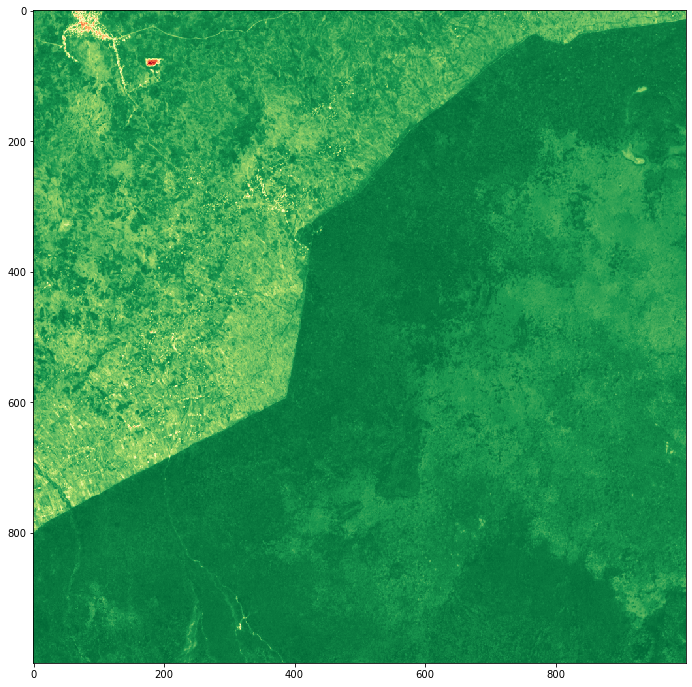

In [3]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(ndvi_data, cmap="RdYlGn")
plt.show()

(3742, 4841)
(3742, 4841)
(3742, 4841)
(3742, 4841)
(3742, 4841)


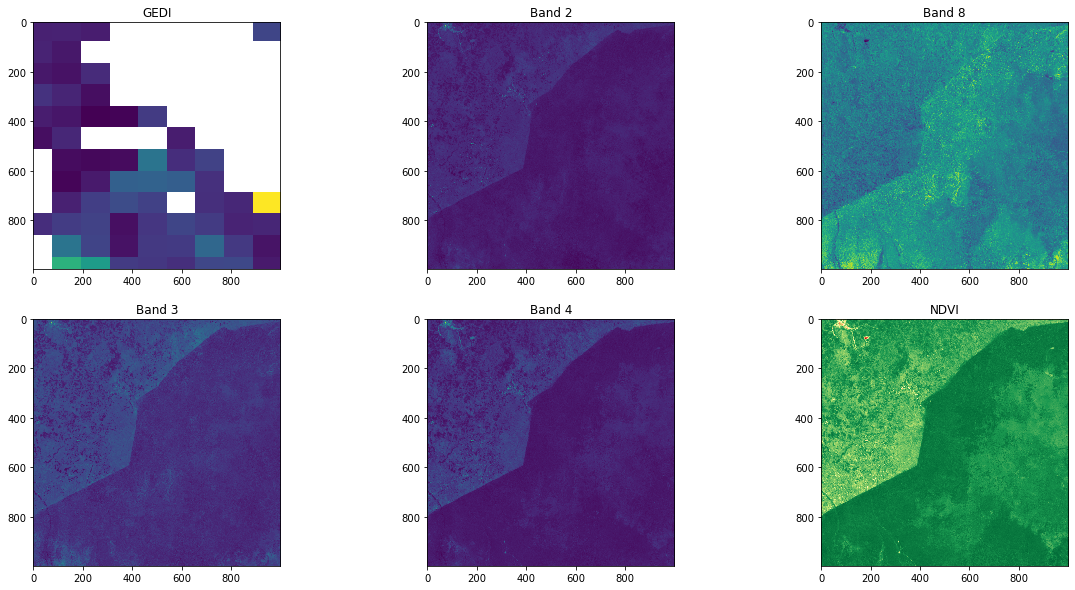

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio
from rasterio.windows import Window
gedi_output = "/shared_space/G1/gedi/gedi_cropped_10m_res.tif"
#window = Window(1000, 1000, 1000,  1000)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

with rasterio.open(gedi_output) as gedi_src:
    print(gedi_src.shape)
    gedi_data = gedi_src.read(1, masked=True, window=window)
    axes[0,0].imshow(gedi_data)
    axes[0,0].set_title("GEDI")
 
with rasterio.open("/shared_space/G1/s2/B02_composite.tif") as b2_src:
    print(b2_src.shape)
    b2_data = b2_src.read(1, masked=True, window=window)
    b2_data[b2_data > 8000] = ma.masked
    axes[0,1].imshow(b2_data)
    axes[0,1].set_title("Band 2")
    
with rasterio.open("/shared_space/G1/s2/B03_composite.tif") as b3_src:
    print(b3_src.shape)
    b3_data = b3_src.read(1, masked=True, window=window)
    b3_data[b3_data > 8000] = ma.masked
    axes[1,0].imshow(b3_data)
    axes[1,0].set_title("Band 3")
    
with rasterio.open("/shared_space/G1/s2/B04_composite.tif") as b4_src:
    print(b4_src.shape)
    b4_data = b4_src.read(1, masked=True, window=window)
    b4_data[b4_data > 8000] = ma.masked
    axes[1,1].imshow(b4_data)
    axes[1,1].set_title("Band 4")
    
with rasterio.open("/shared_space/G1/s2/B08_composite.tif") as b8_src:
    print(b8_src.shape)
    b8_data = b8_src.read(1, masked=True, window=window)
    b8_data[b8_data > 8000] = ma.masked
    axes[0,2].imshow(b8_data)
    axes[0,2].set_title("Band 8")

    
axes[1,2].imshow(ndvi_data, cmap="RdYlGn")
axes[1,2].set_title("NDVI")
plt.show()

In [10]:
mask = np.ma.getmaskarray(gedi_data)

obs = gedi_data.reshape(gedi_data.size)
print('obs shape:', obs.shape)

b2_reshape = b2_data.reshape(gedi_data.size)
b3_reshape = b3_data.reshape(gedi_data.size)
b4_reshape = b4_data.reshape(gedi_data.size)
b8_reshape = b8_data.reshape(gedi_data.size)
ndvi_reshape = ndvi_data.reshape(gedi_data.size)

X = np.vstack((b2_reshape,b3_reshape, b4_reshape, b8_reshape, ndvi_reshape)).T
print('X shape:', X.shape)

obs shape: (1000000,)
X shape: (1000000, 5)


In [11]:
b8_masked = np.ma.masked_array(b8_data, mask=mask)
b4_masked = np.ma.masked_array(b4_data, mask=mask)
b3_masked = np.ma.masked_array(b3_data, mask=mask)
b2_masked = np.ma.masked_array(b2_data, mask=mask)
ndvi_masked = np.ma.masked_array(ndvi_data, mask=mask)

b2_r = b2_masked.reshape(gedi_data.size)
b3_r = b3_masked.reshape(gedi_data.size)
b4_r = b4_masked.reshape(gedi_data.size)
b8_r = b8_masked.reshape(gedi_data.size)
ndvi_r = ndvi_masked.reshape(gedi_data.size)

predictors = np.vstack((b2_r, b3_r, b4_r, b8_r, ndvi_r)).T
print('predictors shape:', predictors.shape)

predictors shape: (1000000, 5)


In [12]:
idx = np.random.choice(obs.size, obs.size, replace=False)
m = np.zeros(obs.size).astype(np.int)
m[idx] = 1
m = m.astype(np.bool)

In [ ]:
import sklearn.ensemble

clf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=1, oob_score=True)
clf = clf.fit(predictors[m,:], obs[m])

print('OOB score: ', clf.oob_score_)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(clf.predict(X).reshape(gedi_data.shape))
cb = plt.colorbar(orientation='horizontal', pad=0.03)
cb.ax.tick_params(labelsize=16)